In [1]:
import yoda
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
plt.rcParams['text.usetex'] = True
import numba as nb

Welcome to JupyROOT 6.30/02


/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [85]:
def return_data_hist_yoda(hist_name='d01-x01-y01'):
    # print('data hist name = ', hist_name)
    data_hist_path = os.path.join(os.getcwd(), 'rivet_histograms', 'data', 'ALEPH_1996_S3486095.yoda')
    tree_name_data='/REF/ALEPH_1996_S3486095'
    yoda_file = yoda.readYODA(data_hist_path)
    full_hist_name = '%s/%s' % (tree_name_data, hist_name)
    yoda_hist = yoda_file[full_hist_name]
    hist_edges = yoda_hist.xVals()
    hist_values = yoda_hist.yVals()
    hist_errs = yoda_hist.yErrs()[:,0]
    return hist_edges, hist_values, hist_errs

def return_simulation_hist_yoda(filename = 'ALEPH_1996_S3486095_card_0.yoda', hist_name='d01-x01-y01'):
    # print('simulation hist name = ', hist_name)
    simulation_hist_path = os.path.join(os.getcwd(), 'rivet_histograms', 'simulation', filename)
    yoda_file = yoda.readYODA(simulation_hist_path)
    tree_name_simulation='/ALEPH_1996_S3486095'
    
    full_hist_name = '%s/%s' % (tree_name_simulation, hist_name)
    yoda_hist = yoda_file[full_hist_name]
    hist_edges = yoda_hist.xVals()
    hist_values = yoda_hist.yVals()
    hist_errs = yoda_hist.yErrs()
    return hist_edges, hist_values, hist_errs

def return_newseeds_hist_yoda(filename, hist_name='d01-x01-y01'):
    # print('simulation hist name = ', hist_name)
    simulation_hist_path = os.path.join(os.getcwd(), 'rivet_histograms', 'newseeds', filename)
    yoda_file = yoda.read(simulation_hist_path)
    tree_name_simulation='/ALEPH_1996_S3486095'
    
    full_hist_name = '%s/%s' % (tree_name_simulation, hist_name)
    yoda_hist = yoda_file[full_hist_name]
    hist_edges = yoda_hist.xVals()
    hist_values = yoda_hist.yVals()
    hist_errs = yoda_hist.yErrs()
    return hist_edges, hist_values, hist_errs


def get_hist_names():
    hist_names=[]
    for i in range(1,43):
        hist_names.append('d{:02d}-x01-y01'.format(i) )
        #13-16 and 24 not present in yoda files
    hist_names.remove('d13-x01-y01')
    hist_names.remove('d14-x01-y01')
    hist_names.remove('d15-x01-y01')
    hist_names.remove('d16-x01-y01')
    hist_names.remove('d24-x01-y01')
    # d25-x01-y01 gives error of unequal lengths
    # hist_names.remove('d25-x01-y01')
    # hist_names.remove('d26-x01-y01')
    # hist_names.remove('d27-x01-y01')
    #19-23 are empty
    hist_names.remove('d19-x01-y01')
    hist_names.remove('d20-x01-y01')
    hist_names.remove('d21-x01-y01')
    hist_names.remove('d22-x01-y01')
    hist_names.remove('d23-x01-y01')
    #36 gives a huge chi2 (=10^18) for unknown reason
    hist_names.remove('d36-x01-y01')
    # 41
    hist_names.remove('d41-x01-y01')
    hist_names.remove('d42-x01-y01')

    return hist_names
@nb.njit(parallel=True,fastmath=True)
def chi2(data_hist, data_errs, sim_hist, sim_errs, print_=True):
    assert len(data_hist) == len(sim_hist)
    select = sim_hist > 0.0
    hsim = sim_hist[select]
    hdat = data_hist[select]
    sim_errs = sim_errs[select]
    data_errs = data_errs[select]
    
    
    num = (hdat - hsim)**2
    den = np.sqrt(hsim + sim_errs**2 + data_errs**2) 
    den = np.where(den >0, den, 1)
    
    chi_2 =(num/den).sum()
    chi_2_per_dof =chi_2/len(hdat) 


    chi2 = np.sqrt(chi_2_per_dof)

    
    if print_==True:
        print('scaled chi2 per dof = \t', chi2)
    return chi2
    
def overall_chi2_observed_pred(sim_yoda_file='ALEPH_1996_S3486095_card_0.yoda', print_=True):
    """ returns the chi2 between the actually observed data and the predicted simulation"""

    hist_names = get_hist_names()
    overall_chi2 = 0
    for hist_name in hist_names:
        data_hist_edges, data_hist, data_hist_errs = return_data_hist_yoda(hist_name=hist_name)
        simulation_hist_edges, simulation_hist, simulation_hist_errs = return_simulation_hist_yoda(filename =sim_yoda_file , hist_name=hist_name)
        chi2_ = chi2(data_hist, data_hist_errs, simulation_hist, simulation_hist_errs, print_=print_)
        overall_chi2 = overall_chi2 +chi2_

    if print_==True:
        print('overall chi2= ', overall_chi2)
    return overall_chi2
def overall_chi2_shuffledpred_pred(sim_yoda_file='ALEPH_1996_S3486095_card_0.yoda', shuffled_sim_yoda_file = 'ALEPH_1996_S3486095_card_1.yoda',print_=True):
    """ returns the chi2 between the simulated pre"""

    hist_names = get_hist_names()
    overall_chi2 = 0
    for hist_name in hist_names:
        data_hist_edges, data_hist, data_hist_errs = return_simulation_hist_yoda(filename =shuffled_sim_yoda_file , hist_name=hist_name)
        simulation_hist_edges, simulation_hist, simulation_hist_errs = return_simulation_hist_yoda(filename =sim_yoda_file , hist_name=hist_name)
        
        chi2_ = chi2(data_hist, data_hist_errs, simulation_hist, simulation_hist_errs, print_=print_)
        overall_chi2 = overall_chi2 +chi2_

    if print_==True:
        print('overall chi2= ', overall_chi2)
    return overall_chi2

def extract_numbers(s):
    import re
    
    return [int(x) if x.isdigit() else x for x in re.split('([0-9]+)', s)]



In [94]:
def plt_sim_data_hist(ax, hist_name='d05-x01-y01', filename='ALEPH_1996_S3486095_card_0.yoda', label=None):
    data_hist_0_edges, data_hist_0, data_hist_0_errs = return_data_hist_yoda(hist_name)
    simulation_hist_0_edges, simulation_hist_0, simulation_hist_errs = return_simulation_hist_yoda(filename = filename, hist_name=hist_name)
    ax.step(y=data_hist_0, x= data_hist_0_edges, label='data {}'.format( hist_name), color='black')
    if label is not None:
        LABEL = 'simulation {}'.format(hist_name)
        ax.step(y=simulation_hist_0, x=simulation_hist_0_edges, label=LABEL, alpha=0.5)
    else:
         ax.step(y=simulation_hist_0, x=simulation_hist_0_edges, alpha=0.3)
    # ax.errorbar(y=data_hist_0, x= data_hist_0_edges, yerr = data_hist_0_errs, marker = '+', markeredgecolor='black',label='data {}'.format( hist_name))
    # ax.errorbar(y=simulation_hist_0, x=simulation_hist_0_edges, yerr = simulation_hist_errs, marker='+',markeredgecolor='black', label='simulation {}'.format(hist_name))
    if label is not None:
        ax.legend()

29


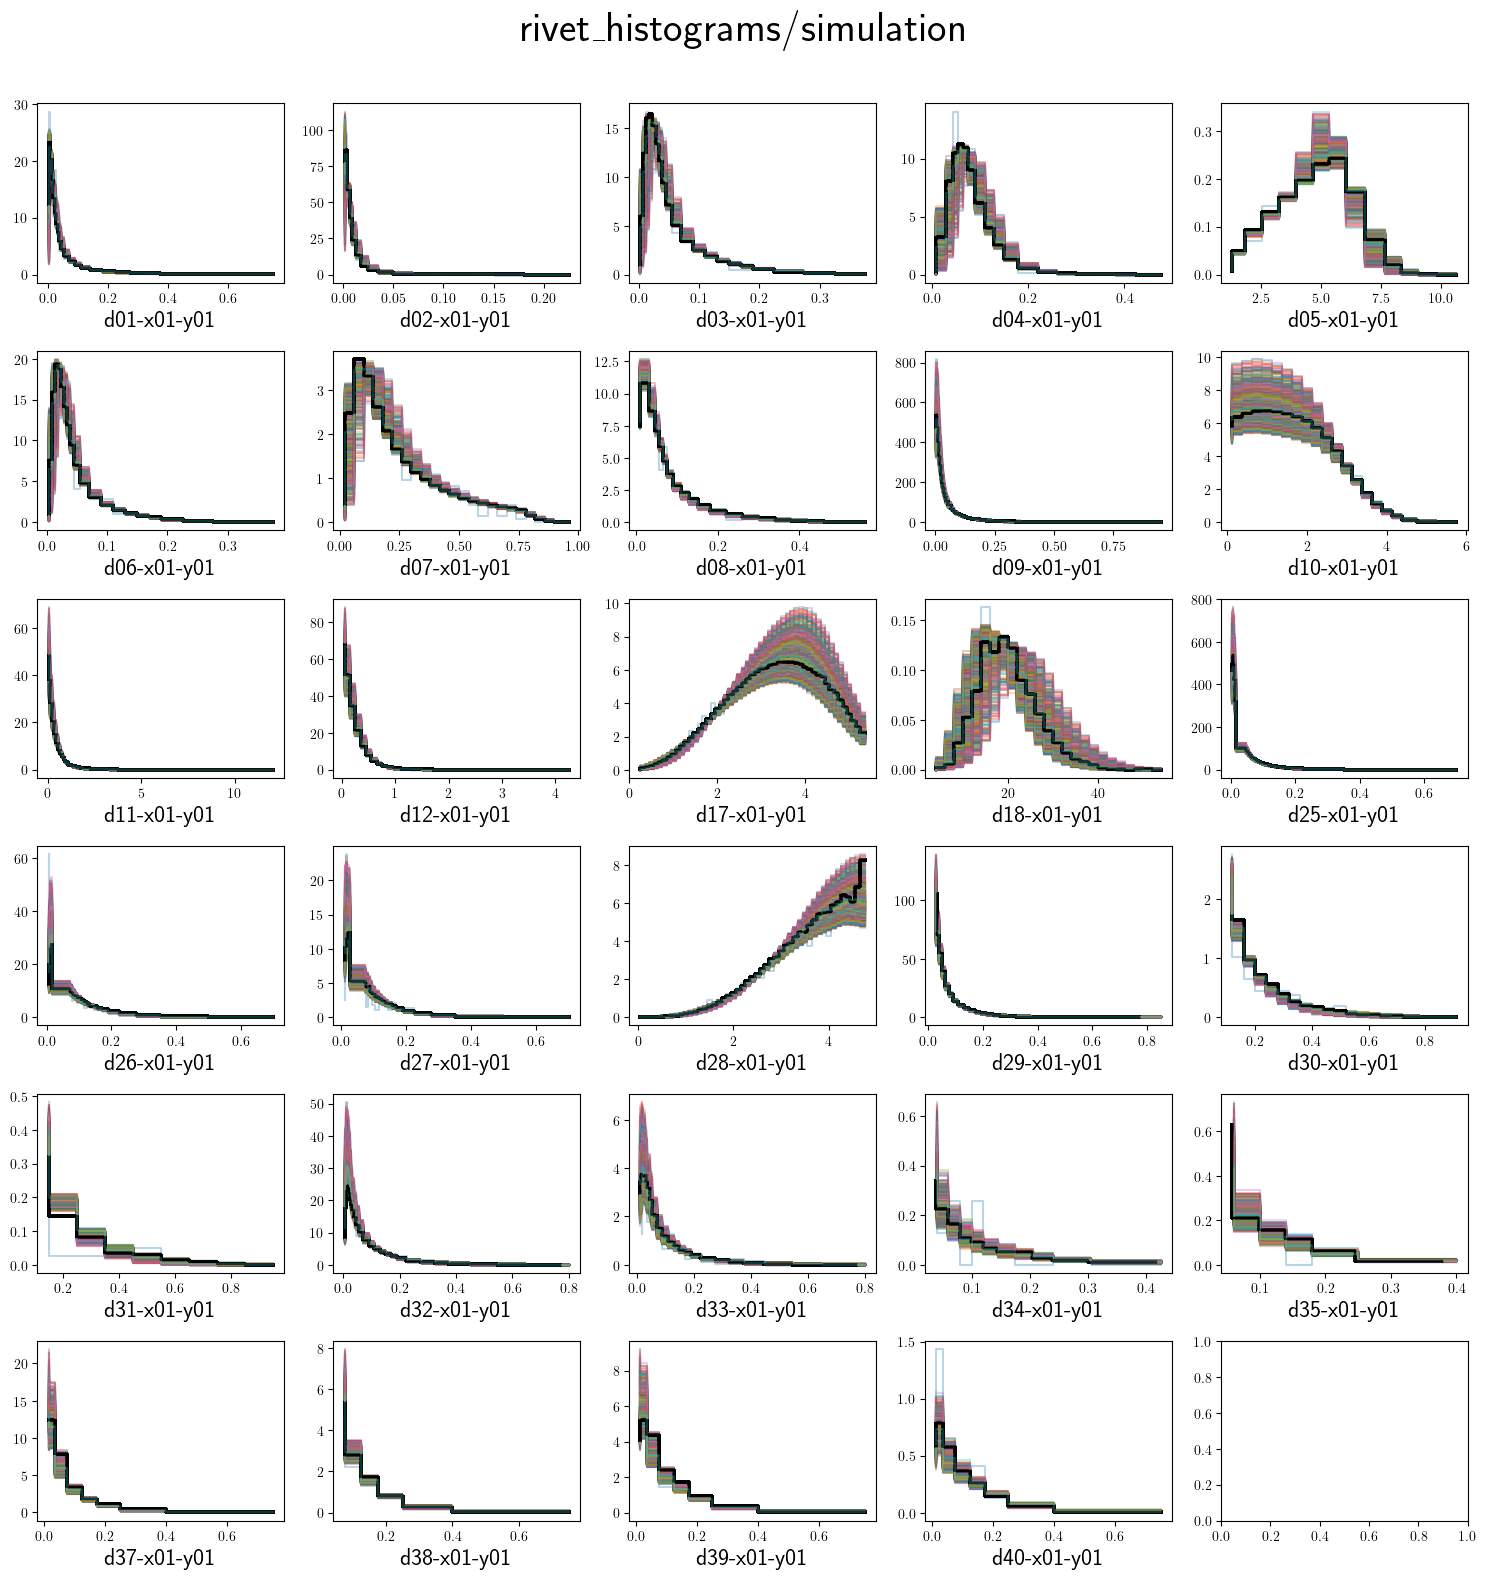

In [102]:
hist_names = get_hist_names()
print(len(hist_names))
nrows=6; ncols = 5
fig, ax = plt.subplots(nrows,ncols, figsize=(15,15), edgecolor='k')

ax = ax.ravel()
sim_files = os.listdir(os.path.join(os.getcwd(), 'rivet_histograms', 'simulation') )
sorted_sim_filenames = sorted(sim_files, key = extract_numbers)
for filename in sorted_sim_filenames:
    for hist_ind, hist_name in enumerate(hist_names):
        plt_sim_data_hist(ax=ax[hist_ind], hist_name=hist_name, filename=filename, label=None)
        ax[hist_ind].set_xlabel(hist_name, fontsize=17)
plt.tight_layout()
plt.suptitle('rivet_histograms/simulation', fontsize=30, y=1.05)
plt.savefig('images/simulation_histograms.pdf')

In [90]:
def plt_newseeds_data_hist(ax, filename, hist_name='d05-x01-y01', label=None):
    data_hist_0_edges, data_hist_0, data_hist_0_errs = return_data_hist_yoda(hist_name)
    simulation_hist_0_edges, simulation_hist_0, simulation_hist_errs = return_newseeds_hist_yoda(filename = filename, hist_name=hist_name)
    ax.step(y=data_hist_0, x= data_hist_0_edges, label='data {}'.format( hist_name), color='black')
    if label is not None:
        LABEL = 'simulation {}'.format(hist_name)
        ax.step(y=simulation_hist_0, x=simulation_hist_0_edges, label=LABEL, alpha=0.4)
    else:
         ax.step(y=simulation_hist_0, x=simulation_hist_0_edges, alpha=0.3)
    # ax.errorbar(y=data_hist_0, x= data_hist_0_edges, yerr = data_hist_0_errs, marker = '+', markeredgecolor='black',label='data {}'.format( hist_name))
    # ax.errorbar(y=simulation_hist_0, x=simulation_hist_0_edges, yerr = simulation_hist_errs, marker='+',markeredgecolor='black', label='simulation {}'.format(hist_name))
    if label is not None:
        ax.legend()

29


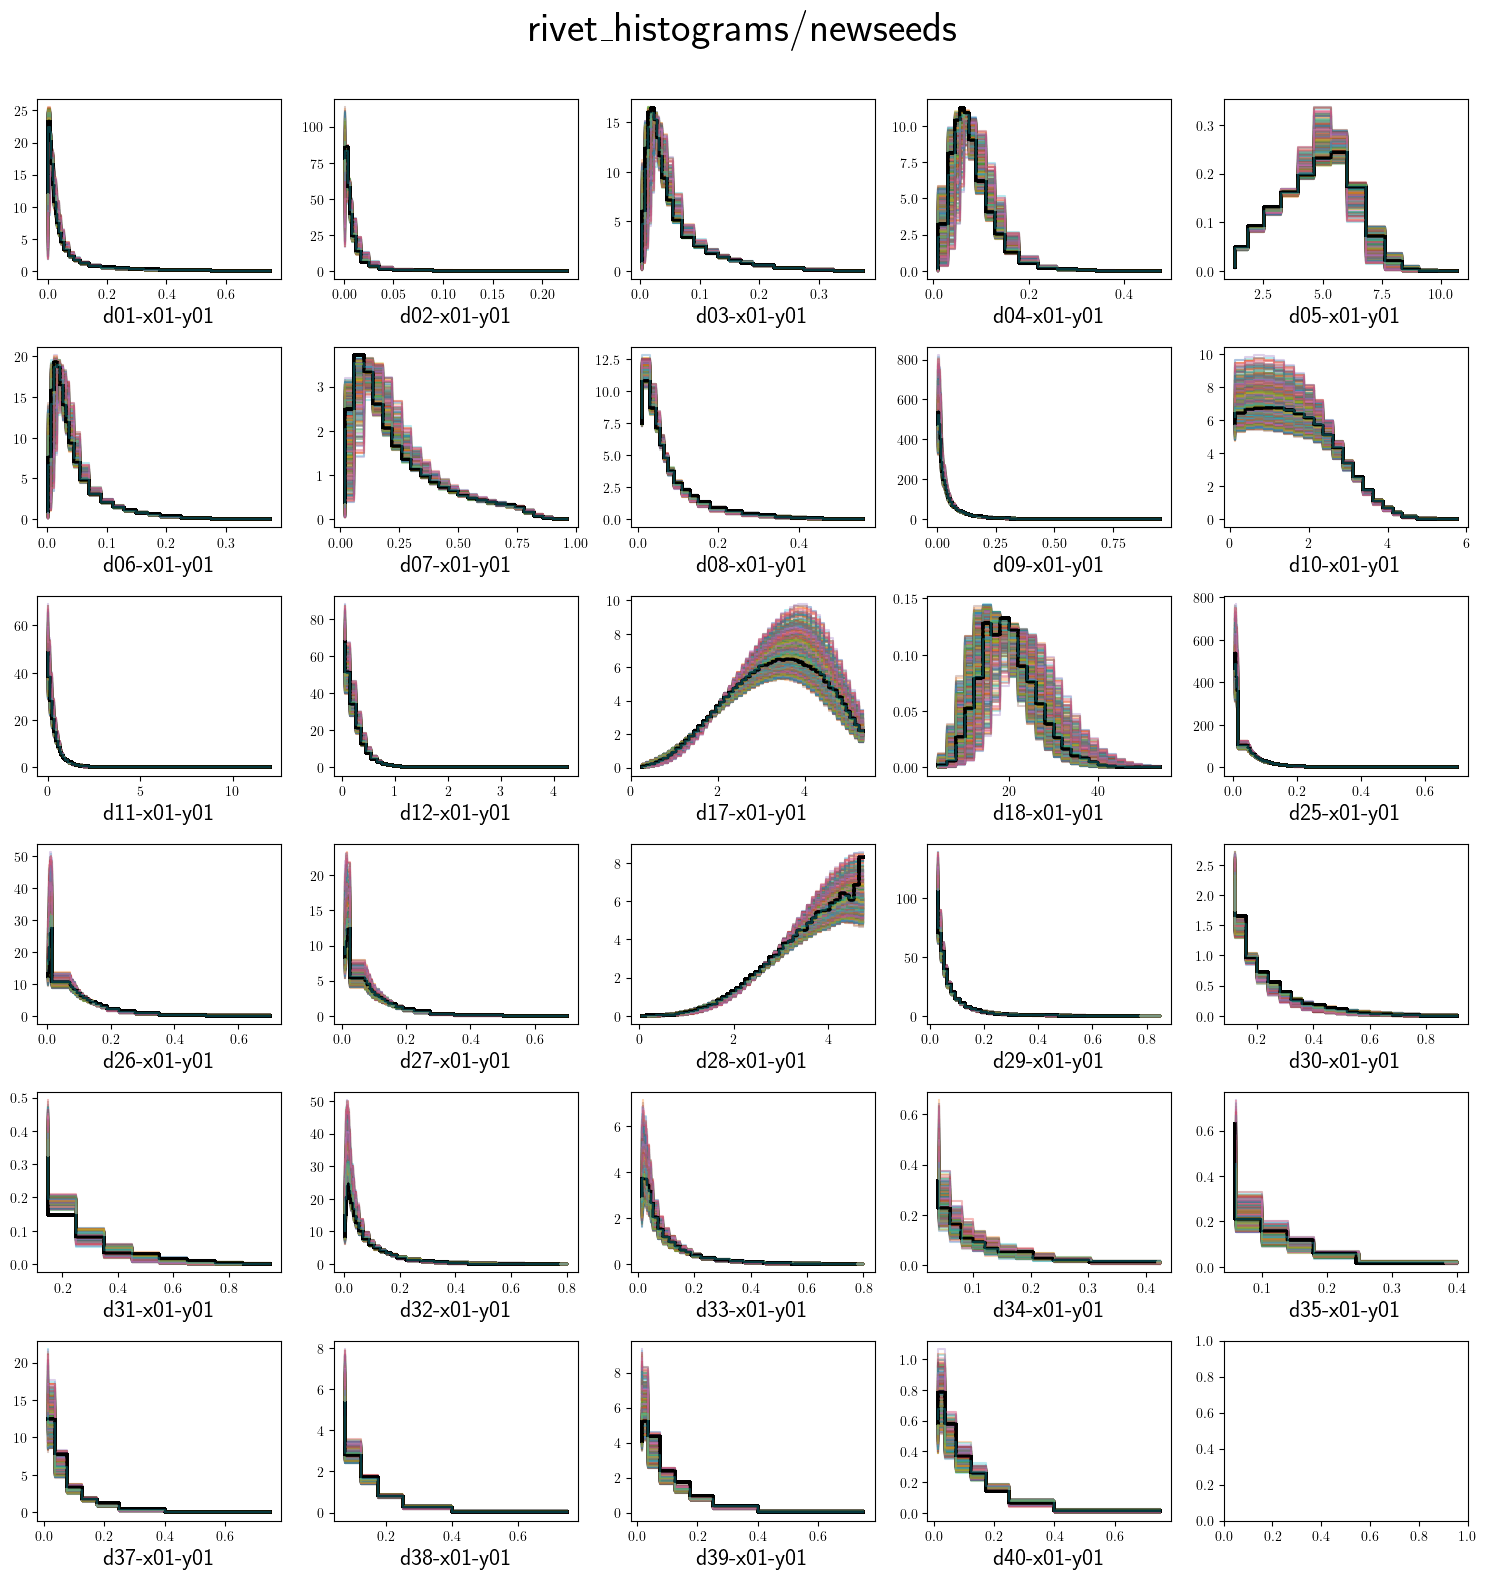

In [104]:
hist_names = get_hist_names()
print(len(hist_names))
nrows=6; ncols = 5
fig, ax = plt.subplots(nrows,ncols, figsize=(15,15), edgecolor='k')
ax = ax.ravel()
newseeds_files = os.listdir(os.path.join(os.getcwd(), 'rivet_histograms', 'newseeds') )
sorted_newseeds_sim_filenames = sorted(newseeds_files, key = extract_numbers)
for filename in sorted_newseeds_sim_filenames:
    for hist_ind, hist_name in enumerate(hist_names):
        plt_newseeds_data_hist(ax=ax[hist_ind], hist_name=hist_name, filename=filename, label=None)
        ax[hist_ind].set_xlabel(hist_name, fontsize=17)
plt.tight_layout()
plt.suptitle('rivet_histograms/newseeds', fontsize=30, y=1.05)
plt.savefig('images/newseeds_histograms.pdf')

In [25]:
hist_names = get_hist_names()
hist_name=hist_names[0]
hist_name

'd01-x01-y01'

In [ ]:
hist_names = get_hist_names()
print(len(hist_names))
nrows=6; ncols = 5
fig, ax = plt.subplots(nrows,ncols, figsize=(15,15), edgecolor='k')
ax = ax.ravel()

In [28]:
return_simulation_hist_yoda(
        filename = sorted_sim_filenames[rowind], 
        hist_name='d01-x01-y01')

[array([0.0025, 0.0075, 0.0125, 0.0175, 0.0225, 0.0275, 0.0325, 0.0375,
        0.045 , 0.055 , 0.07  , 0.09  , 0.11  , 0.14  , 0.18  , 0.225 ,
        0.275 , 0.325 , 0.375 , 0.45  , 0.55  , 0.65  , 0.75  ]),
 array([ 9.207162  , 28.6445    , 18.925832  , 15.856778  , 10.23018   ,
        18.414322  , 10.741688  ,  7.161126  ,  4.092072  ,  5.882353  ,
         2.813299  ,  2.4296675 ,  1.534527  ,  1.2787725 ,  0.95907925,
         0.7672634 ,  0.3069054 ,  0.0511509 ,  0.0511509 ,  0.07672634,
         0.07672634,  0.0511509 ,  0.        ]),
 array([2.17014838, 3.82778265, 3.11138747, 2.84796138, 2.28753754,
        3.06905393, 2.34402816, 1.91389122, 1.02301808, 1.22655534,
        0.59979747, 0.55740403, 0.44297974, 0.28594219, 0.24763321,
        0.19810657, 0.12529359, 0.05115089, 0.05115089, 0.04429798,
        0.04429798, 0.03616914, 0.        ])]

In [59]:
# for rowind, row in df.iterrows():
    # df.loc[rowind, 'sim'] = list([0, 1])
    
# return_simulation_hist_yoda(
# filename = sorted_sim_filenames[rowind], 
# hist_name='d01-x01-y01')[0]



In [61]:
df.loc[1,'sim']=[0,1]

ValueError: Must have equal len keys and value when setting with an iterable